In [43]:
import cv2
import os
import numpy as np
import math
import json
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Activation, Dropout
from keras.layers.pooling import GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam, SGD
from keras.utils import to_categorical, plot_model
from keras.models import load_model, Sequential
from keras.layers.core import Dense, Flatten
from keras.callbacks import ModelCheckpoint

# Data Preprocessing

In [2]:
def video_to_frames(video, resize=(320, 240)):
    """
    Convert video to frame arrays
    """
    # extract frames from a video and return a frame array
    vidcap = cv2.VideoCapture(video)
    frames = []
    while vidcap.isOpened():
        success, image = vidcap.read()
        
        if success:
            frames.append(image)
        else:
            break
    
    cv2.destroyAllWindows()
    vidcap.release()
    
    # resize each frame
    resized_frames = []
    for frame in frames:
        resized_frames.append(cv2.resize(frame, dsize=resize, interpolation=cv2.INTER_CUBIC))
    
    return np.array(resized_frames)

In [3]:
def parse_videos_in_folder(folder_path, label):
    """
    Parse all videos in a folfer and mark all video with the given tag
    """
    train_data = []
    train_label = []
    
    for file_path in os.listdir(folder_path):
        if os.path.splitext(file_path)[1] in (".avi", ".mp4"):
            file_path = folder_path + file_path if folder_path[-1] == '/' else folder_path + '/' + file_path
            print(file_path, label)

            # parse videos into frame arrays
            frames = video_to_frames(file_path)

            train_data.append(frames)
            train_label.append(label)
    
    return train_data, train_label

In [4]:
def merge_dataset(data_1, label_1, data_2, label_2):
    """
    Merge 2 datasets and label sets
    """
    merged_data = data_1 + data_2
    merged_label = label_1 + label_2

    merged_data = np.array(merged_data)
    merged_label = np.array(merged_label)

    return merged_data, merged_label

In [5]:
# Parse train set, validation set and test set
train_data_other, train_label_other = parse_videos_in_folder('dataset/train/other', 0)
train_data_slip, train_label_slip = parse_videos_in_folder('dataset/train/slip', 1)
train_data, train_label = merge_dataset(train_data_other, train_label_other, train_data_slip, train_label_slip)
del train_data_other, train_label_other, train_data_slip, train_label_slip

dataset/train/other/squat_train_20.mp4 0
dataset/train/other/walk_train_6.mp4 0
dataset/train/other/crouch_train_7.mp4 0
dataset/train/other/squat_train_18.mp4 0
dataset/train/other/run_train_11.mp4 0
dataset/train/other/crouch_train_3.mp4 0
dataset/train/other/jump_train_5.mp4 0
dataset/train/other/jump_train_11.mp4 0
dataset/train/other/run_train_2.mp4 0
dataset/train/other/squat_train_8.mp4 0
dataset/train/other/crouch_train_11.mp4 0
dataset/train/other/squat_train_19.mp4 0
dataset/train/other/crouch_train_19.mp4 0
dataset/train/other/bend_train_1.mp4 0
dataset/train/other/walk_train_12.mp4 0
dataset/train/other/walk_train_18.mp4 0
dataset/train/other/jump_train_10.mp4 0
dataset/train/other/run_train_17.mp4 0
dataset/train/other/run_train_16.mp4 0
dataset/train/other/crouch_train_14.mp4 0
dataset/train/other/squat_train_13.mp4 0
dataset/train/other/squat_train_1.mp4 0
dataset/train/other/walk_train_13.mp4 0
dataset/train/other/squat_train_6.mp4 0
dataset/train/other/squat_train_7.mp

In [6]:
valid_data_other, valid_label_other = parse_videos_in_folder('dataset/valid/other', 0)
valid_data_slip, valid_label_slip = parse_videos_in_folder('dataset/valid/slip', 1)
valid_data, valid_label = merge_dataset(valid_data_other, valid_label_other, valid_data_slip, valid_label_slip)
del valid_data_other, valid_label_other, valid_data_slip, valid_label_slip

dataset/valid/other/run_valid_3.mp4 0
dataset/valid/other/walk_valid_2.mp4 0
dataset/valid/other/bend_valid_2.mp4 0
dataset/valid/other/walk_valid_8.mp4 0
dataset/valid/other/crouch_valid_4.mp4 0
dataset/valid/other/jump_valid_3.mp4 0
dataset/valid/other/crouch_valid_8.mp4 0
dataset/valid/other/squat_valid_9.mp4 0
dataset/valid/other/run_valid_20.mp4 0
dataset/valid/other/squat_valid_21.mp4 0
dataset/valid/other/walk_valid_16.mp4 0
dataset/valid/other/jump_valid_15.mp4 0
dataset/valid/other/crouch_valid_13.mp4 0
dataset/valid/other/squat_valid_14.mp4 0
dataset/valid/other/jump_valid_9.mp4 0
dataset/valid/other/crouch_valid_18.mp4 0
dataset/valid/other/bend_valid_11.mp4 0
dataset/valid/other/squat_valid_4.mp4 0
dataset/valid/other/run_valid_15.mp4 0
dataset/valid/other/run_valid_8.mp4 0
dataset/valid/slip/slip_valid_2.mp4 1
dataset/valid/slip/faint_valid_22.mp4 1
dataset/valid/slip/slip_valid_30.mp4 1
dataset/valid/slip/slip_valid_16.mp4 1
dataset/valid/slip/faint_valid_2.mp4 1
dataset/

In [7]:
test_data_other, test_label_other = parse_videos_in_folder('dataset/test/other', 0)
test_data_slip, test_label_slip = parse_videos_in_folder('dataset/test/slip', 1)
test_data, test_label = merge_dataset(test_data_other, test_label_other, test_data_slip, test_label_slip)
del test_data_other, test_label_other, test_data_slip, test_label_slip

dataset/test/other/run_test_4.mp4 0
dataset/test/other/walk_test_4.mp4 0
dataset/test/other/squat_test_6.mp4 0
dataset/test/other/jump_test_3.mp4 0
dataset/test/other/squat_test_1.mp4 0
dataset/test/other/squat_test_3.mp4 0
dataset/test/other/run_test_7.mp4 0
dataset/test/other/walk_test_2.mp4 0
dataset/test/other/crouch_test_2.mp4 0
dataset/test/other/walk_test_3.mp4 0
dataset/test/other/jump_test_1.mp4 0
dataset/test/other/jump_test_2.mp4 0
dataset/test/other/walk_test_1.mp4 0
dataset/test/other/run_test_6.mp4 0
dataset/test/other/run_test_5.mp4 0
dataset/test/other/squat_test_5.mp4 0
dataset/test/other/crouch_test_4.mp4 0
dataset/test/other/run_test_1.mp4 0
dataset/test/other/squat_test_4.mp4 0
dataset/test/other/jump_test_6.mp4 0
dataset/test/other/crouch_test_5.mp4 0
dataset/test/other/jump_test_5.mp4 0
dataset/test/other/squat_test_2.mp4 0
dataset/test/other/run_test_2.mp4 0
dataset/test/other/run_test_3.mp4 0
dataset/test/other/bend_test_1.mp4 0
dataset/test/other/crouch_test_1.

In [8]:
# get the median length of video frame array of the training set
frame_lens = []
for frames in train_data:
    frame_lens.append(len(frames))

median_len = int(np.median(np.array(frame_lens)))
    
print("The median of the frame length is %d." % median_len)

The median of the frame length is 137.


In [9]:
def normalize_frames(frames, length):
    """
    Truncate the excess frames and pad the missing frames using the head & tail frame
    """
    mid = len(frames) // 2
    half_len = length // 2
    if len(frames) >= length:
        norm_frames = frames[mid - half_len : mid + half_len]
    else:
        left = half_len - mid
        norm_frames = []
        for i in range(length):
            if i < left:
                norm_frames.append(frames[0])
            elif i - left < len(frames):
                norm_frames.append(frames[i-left])
            else:
                norm_frames.append(frames[-1])

    return np.array(norm_frames)
    
    
def normalize_frame_array(frame_array, length):
    """
    Normalize all frame arrays and convert it to a numpy array
    """
    norm_frame_list = []
    for frames in frame_array:
        norm_frame_list.append(normalize_frames(frames, length))

    return np.array(norm_frame_list)

In [10]:
# normalize train set, validation set and test set
train_data = normalize_frame_array(train_data, median_len // 2 * 2)
test_data = normalize_frame_array(test_data, median_len // 2 * 2)
valid_data = normalize_frame_array(valid_data, median_len // 2 * 2)

In [11]:
print(train_data.shape, train_label.shape)
print(valid_data.shape, valid_label.shape)
print(test_data.shape, test_label.shape)

(129, 136, 240, 320, 3) (129,)
(32, 136, 240, 320, 3) (32,)
(55, 136, 240, 320, 3) (55,)


In [12]:
# save train set, validation set and test set as a .npy file
np.save('train_data', train_data)
np.save('train_label', train_label)
del train_data, train_label

In [13]:
np.save('valid_data', valid_data)
np.save('valid_label', valid_label)
del valid_data, valid_label

In [14]:
np.save('test_data', test_data)
np.save('test_label', test_label)
del test_data, test_label

# Train Model

### VGG16+LSTM without Dropout

In [2]:
# load train set, validation set and test set from .npy files
train_data = np.load('train_data.npy')
train_label = np.load('train_label.npy')

In [3]:
valid_data = np.load('valid_data.npy')
valid_label = np.load('valid_label.npy')

In [4]:
def sample_frames(dataset, interval=5):
    """
    Sample the video frame arrays by a given interval so that we can shrink the data scale 
    """
    dataset_tmp = []
    for video in dataset:
        dataset_tmp.append(video[::interval])

    return np.array(dataset_tmp)

In [5]:
# sample datasets and convert lables to float type
train_data = sample_frames(train_data)
train_label = train_label.astype('float32')

In [6]:
valid_data = sample_frames(valid_data)
valid_label = valid_label.astype('float32')

In [7]:
# shuffle train set
train_data, train_label = shuffle(train_data, train_label)

In [8]:
# define the input shape of the model using the train set shape
frames, rows, columns, channels = train_data.shape[1], train_data.shape[2], train_data.shape[3], train_data.shape[4]

In [9]:
# create VGG16+LSTM model
model = Sequential()
model.add(TimeDistributed(VGG16(input_shape=(rows, columns, channels), weights="imagenet", include_top=False)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(1024, activation='relu')))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

In [10]:
# set SGD optimizer and compile the model
optimizer = SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [11]:
# set checkpoint for saving models automatically in every epoch
checkpoint = ModelCheckpoint('vgg16_lstm_model_{epoch:d}.h5', period=1)

In [12]:
# set validation set and train the model
history = model.fit(train_data, train_label, epochs=30, batch_size=3, 
                    validation_data=(valid_data, valid_label), callbacks=[checkpoint])

Train on 129 samples, validate on 32 samples
Epoch 1/30
129/129 [==============================] - 121s 937ms/step - loss: 0.6383 - accuracy: 0.6434 - val_loss: 0.5990 - val_accuracy: 0.6250
Epoch 2/30
129/129 [==============================] - 95s 733ms/step - loss: 0.5674 - accuracy: 0.6822 - val_loss: 0.5428 - val_accuracy: 0.6250
Epoch 3/30
129/129 [==============================] - 95s 733ms/step - loss: 0.5179 - accuracy: 0.7519 - val_loss: 0.4915 - val_accuracy: 0.7812
Epoch 4/30
129/129 [==============================] - 95s 733ms/step - loss: 0.4520 - accuracy: 0.7984 - val_loss: 0.4405 - val_accuracy: 0.9375
Epoch 5/30
129/129 [==============================] - 95s 733ms/step - loss: 0.3935 - accuracy: 0.9302 - val_loss: 0.3988 - val_accuracy: 0.8750
Epoch 6/30
129/129 [==============================] - 94s 732ms/step - loss: 0.3515 - accuracy: 0.9535 - val_loss: 0.3569 - val_accuracy: 0.9375
Epoch 7/30
129/129 [==============================] - 94s 731ms/step - loss: 0.3141 

### Plotting the Training and Validation Loss

In [13]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']

In [14]:
epochs = range(1, len(loss_values) + 1)

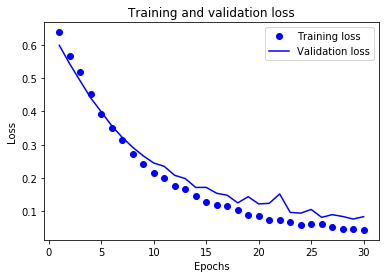

In [15]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Plotting the Training and Validation Accuracy

In [16]:
plt.clf()
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']

<Figure size 432x288 with 0 Axes>

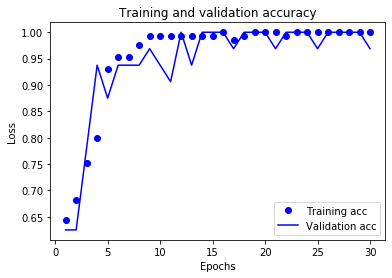

In [17]:
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### VGG16+LSTM with Dropout

In [18]:
# create VGG16+LSTM model
model = Sequential()
model.add(TimeDistributed(VGG16(input_shape=(rows, columns, channels), weights="imagenet", include_top=False)))
model.add(Dropout(0.1))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(1024, activation='relu')))
# model.add(Dropout(0.1))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

In [19]:
# set SGD optimizer and compile the model
optimizer = SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [20]:
# set checkpoint for saving models automatically in every epoch
checkpoint = ModelCheckpoint('vgg16_lstm_model_dropout_{epoch:d}.h5', period=1)

In [21]:
# set validation set and train the model
history_dropout = model.fit(train_data, train_label, epochs=30, batch_size=3, 
                    validation_data=(valid_data, valid_label), callbacks=[checkpoint])

Train on 129 samples, validate on 32 samples
Epoch 1/30
129/129 [==============================] - 95s 734ms/step - loss: 0.6612 - accuracy: 0.5814 - val_loss: 0.6075 - val_accuracy: 0.6250
Epoch 2/30
129/129 [==============================] - 94s 726ms/step - loss: 0.5930 - accuracy: 0.6512 - val_loss: 0.5662 - val_accuracy: 0.6562
Epoch 3/30
129/129 [==============================] - 94s 727ms/step - loss: 0.5512 - accuracy: 0.7054 - val_loss: 0.5334 - val_accuracy: 0.6562
Epoch 4/30
129/129 [==============================] - 94s 727ms/step - loss: 0.5081 - accuracy: 0.7442 - val_loss: 0.5003 - val_accuracy: 0.6562
Epoch 5/30
129/129 [==============================] - 94s 726ms/step - loss: 0.4625 - accuracy: 0.7984 - val_loss: 0.4639 - val_accuracy: 0.7812
Epoch 6/30
129/129 [==============================] - 94s 726ms/step - loss: 0.4251 - accuracy: 0.8837 - val_loss: 0.4363 - val_accuracy: 0.8125
Epoch 7/30
129/129 [==============================] - 94s 725ms/step - loss: 0.3762 -

### Plotting the Training and Validation Loss

In [22]:
history_dict = history_dropout.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']

In [23]:
epochs = range(1, len(loss_values) + 1)

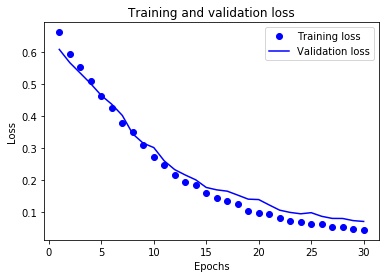

In [24]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Plotting the Training and Validation Accuracy

In [25]:
plt.clf()
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']

<Figure size 432x288 with 0 Axes>

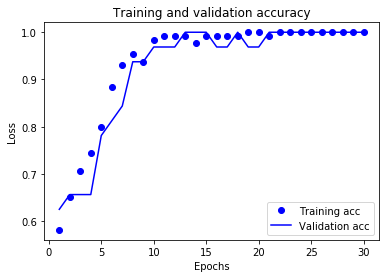

In [26]:
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model

### Evaluate VGG16+LSTM Model without Dropout

In [31]:
# load test dataset
test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')

In [32]:
test_data = sample_frames(test_data)
test_label = test_label.astype('float32')

In [33]:
# shuffle test set
test_data, test_label = shuffle(test_data, test_label)

In [34]:
best_model_name, best_score, best_accuracy = "not found", 0., 0.

In [35]:
# evaluate the test dataset on every epoch
for epoch in range(1, 31):
    model_name = "vgg16_lstm_model_%d.h5" % epoch
    print("Evaludating model %s" % model_name)
    model = load_model(model_name)
    score, acc = model.evaluate(test_data, test_label, batch_size=5)
    print("Epoch #%d: score = %f, accuracy = %f" % (epoch, score, acc))
    
    if acc > best_accuracy:
        best_model_name = model_name
        best_score = score
        best_accuracy = acc

Evaludating model vgg16_lstm_model_1.h5
55/55 [==============================] - 13s 230ms/step
Epoch #1: score = 0.690966, accuracy = 0.527273
Evaludating model vgg16_lstm_model_2.h5
55/55 [==============================] - 13s 234ms/step
Epoch #2: score = 0.685872, accuracy = 0.509091
Evaludating model vgg16_lstm_model_3.h5
55/55 [==============================] - 13s 236ms/step
Epoch #3: score = 0.682567, accuracy = 0.527273
Evaludating model vgg16_lstm_model_4.h5
55/55 [==============================] - 13s 232ms/step
Epoch #4: score = 0.678439, accuracy = 0.563636
Evaludating model vgg16_lstm_model_5.h5
55/55 [==============================] - 13s 231ms/step
Epoch #5: score = 0.666324, accuracy = 0.545455
Evaludating model vgg16_lstm_model_6.h5
55/55 [==============================] - 13s 231ms/step
Epoch #6: score = 0.661672, accuracy = 0.545455
Evaludating model vgg16_lstm_model_7.h5
55/55 [==============================] - 13s 231ms/step
Epoch #7: score = 0.657140, accuracy = 0

### Evaluate VGG16+LSTM Model with Dropout

In [36]:
# evaluate the test dataset on every epoch
for epoch in range(1, 31):
    model_name = "vgg16_lstm_model_dropout_%d.h5" % epoch
    print("Evaludating model %s" % model_name)
    model = load_model(model_name)
    score, acc = model.evaluate(test_data, test_label, batch_size=5)
    print("Epoch #%d: score = %f, accuracy = %f" % (epoch, score, acc))
    
    if acc > best_accuracy:
        best_model_name = model_name
        best_score = score
        best_accuracy = acc

Evaludating model vgg16_lstm_model_dropout_1.h5
55/55 [==============================] - 13s 232ms/step
Epoch #1: score = 0.698693, accuracy = 0.545455
Evaludating model vgg16_lstm_model_dropout_2.h5
55/55 [==============================] - 13s 232ms/step
Epoch #2: score = 0.685561, accuracy = 0.563636
Evaludating model vgg16_lstm_model_dropout_3.h5
55/55 [==============================] - 13s 232ms/step
Epoch #3: score = 0.676552, accuracy = 0.563636
Evaludating model vgg16_lstm_model_dropout_4.h5
55/55 [==============================] - 13s 233ms/step
Epoch #4: score = 0.672982, accuracy = 0.563636
Evaludating model vgg16_lstm_model_dropout_5.h5
55/55 [==============================] - 13s 232ms/step
Epoch #5: score = 0.672735, accuracy = 0.563636
Evaludating model vgg16_lstm_model_dropout_6.h5
55/55 [==============================] - 13s 233ms/step
Epoch #6: score = 0.671688, accuracy = 0.563636
Evaludating model vgg16_lstm_model_dropout_7.h5
55/55 [==============================] -

### Best Model

In [38]:
# evaluate on the best model
best_model = load_model(best_model_name)
prediction_label = best_model.predict(test_data, batch_size=5)
print("The best model: model = %s, score = %f, accuracy = %f" % (best_model_name, best_score, best_accuracy))

The best model: model = vgg16_lstm_model_dropout_10.h5, score = 0.663704, accuracy = 0.709091


In [39]:
timestamp = range(len(test_data))

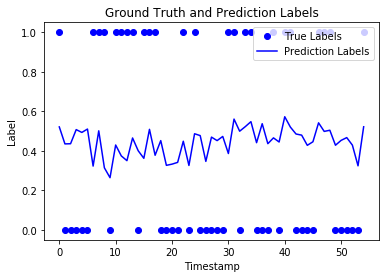

In [40]:
plt.plot(timestamp, test_label, 'bo', label='True Labels')
plt.plot(timestamp, prediction_label, 'b', label='Prediction Labels')
plt.title('Ground Truth and Prediction Labels')
plt.xlabel('Timestamp')
plt.ylabel('Label')
plt.legend()
plt.show()

### Export to JSON File

In [52]:
data = []
for i in range(len(test_data)):
    data.append([str(timestamp[i]), str(prediction_label[i][0])])

In [53]:
# dump to file system
with open('timeLabel.json', 'w', encoding='utf-8') as f:
    json.dump({'slip': data}, f, ensure_ascii=False, indent=4)